In [1]:
# To create python file:
# jupyter nbconvert --to=python lang_model_new.ipynb

import utils.data_import as data_import
import utils.wiki_data as wiki_data
import utils.ml_utils as ml_utils
import model.neural as neural

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data, vocab

import os, sys
import pdb
import pandas as pd
import numpy as np
import math
#from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

import importlib

import settings

np.random.seed(123)

In [2]:
in_notebook = ml_utils.in_ipynb()
print('Running in notebook:', in_notebook)

Running in notebook: True


In [3]:
cuda = torch.cuda.is_available()
if cuda:
    print('Cuda is available!')
    print('Device:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('No cuda.')

if in_notebook:
    import matplotlib.pyplot as plt
    %matplotlib inline

Cuda is available!
Device: Tesla V100-SXM2-16GB


In [4]:
corpus = wiki_data.WikiCorpus(file_path=settings.wikitext_path, lines=settings.lines)

Generated train: 121,423,332 tokens (1,801,349 lines)
Generated valid: 258,407 tokens (3,759 lines)
Generated test:  288,663 tokens (4,357 lines)
Generated vocab: 226,993
Generated oov:   0.4%


In [5]:
if settings.maxvocabsize < len(corpus.vocab):
    remove = corpus.vocab.least_frequent(len(corpus.vocab) - settings.maxvocabsize + 1)
    remove = [tok[0] for tok in remove]
    corpus.remove_token_list(remove)
    
corpus.vocab.export_vocab('vocab.p')

Note: keeping special token <pad>
Processing 166,993 tokens for removal.
Updating corpus vocabulary... 

100%|██████████| 226993/226993 [06:49<00:00, 553.67it/s]

166,993 removed.
Replacing tokens in train... 

102,296,412 substitutions.
Replacing tokens in valid... 215,302 substitutions.
Replacing tokens in test... 241,947 substitutions.
Final vocabulary size: 60,000 tokens
Exporting vocab to vocab.p... Done.


In [6]:
corpus.batchify(batch_size=settings.batch_size, seq_length=settings.window_size)

Batchifying train... Done.  torch.Size([1517791, 80])
Batchifying valid... Done.  torch.Size([3230, 80])
Batchifying test...  Done.  torch.Size([3608, 80])


287 270 1806 299 70 16 380 408 2718 12 16 3 19644 1429 3573 1759 1576 44 16 7026 29 30 29 10064 15 16 2726 80 16 3 15102 3 48568 139 3 51670 129 2995 216 3984 1303 114 16 35175 92 16 553 659 15 16 33 14 1 3 22 26 3000 12 3 51670 708 1375 29 12 29 3278 3940 37 2381 2807 None
up only 19 points during the entire regular season , the <upcase> knights lost 32 – 26 in the quarter @ - @ finals of the playoffs against the <upcase> centennial <upcase> centaurs after <upcase> mccarty was stopped one yard away from the endzone on the last play of the game . <eol> <upcase> as a senior , <upcase> mccarty recorded 2 @ , @ 400 yards and scored 33 None
tensor([   44,    16,     3,  1064,    12,   216,    15,    16,     3,     2,
           29,    30,    29,   330,     3,  8166,  6917,    16,     3,    11,
            2,     3,     2,     3, 45850,    12,   312,   129,  9864,    15,
          303,    26,  6276,  3640,    12,    37,  1259,    47,  3642,    14,
            3,    35,  1701,     3,  2846, 

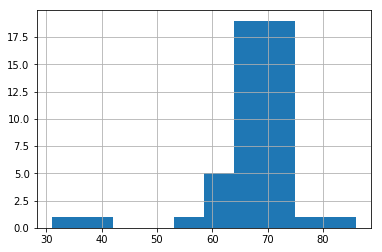

In [7]:
if in_notebook:
    print(corpus.valid.show_itoklist(29629,29629+70))
    print(corpus.valid.show_stoklist(corpus.vocab, 29629,29629+70))
    print(corpus.valid.batch_matrix[:70,1])
    df = corpus.valid.batch_stats()
    df.hist()

In [8]:
train_dl = wiki_data.WikiTextDataset(corpus.train)
valid_dl = wiki_data.WikiTextDataset(corpus.valid)
test_dl = wiki_data.WikiTextDataset(corpus.test)

In [9]:
model = neural.lang_model_LSTM(vocab_dim=len(corpus.vocab),
                               emb_dim=settings.emb_dim,
                               hidden_dim=settings.hidden_dim,
                               n_layers=settings.num_layers,
                               dropout=settings.dropout
                              )

In [10]:
if cuda:
    model = model.cuda()
loss_func = nn.CrossEntropyLoss()

In [11]:
print(model)

lang_model_LSTM(
  (embedding): Embedding(60000, 400)
  (lstm): LSTM(400, 1150, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=2300, out_features=60000, bias=True)
  (dropout): Dropout(p=0.4)
)


In [12]:
#model = torch.load('model_weights.pt')

In [13]:
missclass = []
missclass_next = []
losses = []

In [14]:
def run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
               losses=[], missclass=[]):
    
    opt = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
    #opt = optim.Adam(model.parameters(), lr=0.001)
    
    
    scheduler = optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.8)
    
    best_missclass_te = 1e10
    
    try: # Allow for user interrupt
 
        for epoch in range(1, epochs + 1):
            scheduler.step()
            running_loss = 0.0
            running_corrects = 0
            model.train() # turn on training mode

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            #pdb.set_trace()

            for x, y in tqdm(train_dl, desc='Train {}/{}'.format(epoch, epochs)):
                opt.zero_grad()
                
                if cuda:
                    x = x.cuda()
                    y = y.cuda()

                preds = model(x)
                loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                loss.backward()
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                opt.step()

                running_loss += loss.item() * x.size(0) / x.size(1)

                _, y_preds = torch.max(preds, dim=2)
                num_correct += torch.sum(y == y_preds).item()
                num_vals += y.size(0)*y.size(1)
                
                miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_tr = 1 - num_correct / num_vals
            miss_next_wd_rate_tr = miss_next_wd / next_wd_tot

            epoch_loss = running_loss / len(train_dl)

            num_vals = 0
            num_correct = 0
            miss_next_wd = 0
            next_wd_tot = 0

            # calculate the validation loss for this epoch
            val_loss = 0.0
            model.eval() # turn on evaluation mode
            
            with torch.no_grad():
                for x, y in tqdm(valid_dl, desc='Valid {}/{}'.format(epoch, epochs)):
                    if cuda:
                        x = x.cuda()
                        y = y.cuda()   
                        
                    preds = model(x)
                    loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())

                    val_loss += loss.item() * x.size(0) / x.size(1)

                    _, y_preds = torch.max(preds, dim=2)
                    num_correct += torch.sum(y == y_preds).item()
                    num_vals += y.size(0)*y.size(1)
                    
                    miss_next_wd += ml_utils.calc_miss_next_wds(y, y_preds)
                    next_wd_tot += y.size(1)

            #pdb.set_trace()

            missclass_te = 1 - num_correct / num_vals
            val_loss /= len(valid_dl)
            
            miss_next_wd_rate_val = miss_next_wd / next_wd_tot
            
            missclass_next.append((miss_next_wd_rate_tr, miss_next_wd_rate_val))
            missclass.append((missclass_tr, missclass_te))
            losses.append((epoch_loss, val_loss))

            print('Epoch: {}/{}, Loss: [{:.4f}, {:.4f}], Ppl: [{:6.2f}, {:6.2f}], Miss: [{:.2%}, {:.2%}], [{:.2%}, {:.2%}]'\
                  .format(epoch, epochs, epoch_loss, val_loss, 
                          math.exp(epoch_loss), math.exp(val_loss), 
                          missclass_tr, missclass_te,
                          miss_next_wd_rate_tr, miss_next_wd_rate_val))
            sys.stdout.flush()

            if missclass_te < best_missclass_te: 
                print('Saving weights file...', end=' ', flush=True)
                torch.save(model, 'model_weights.pt')
                print('Done.', flush=True)
                best_missclass_te = missclass_te
            
    except KeyboardInterrupt:
        print('Stopping with latest weights.')
        
    return model, opt, losses, missclass

In [ ]:
model, opt, losses, missclass = run_epochs(model, train_dl, valid_dl, epochs=settings.epochs,
                                           losses=losses, missclass=missclass)

Train 1/100:   8%|▊         | 1806/22406 [20:41<3:55:57,  1.46it/s]

In [ ]:
x, y = next(iter(valid_dl))
if cuda:
    x = x.cuda()
    y = y.cuda()
loss_func = nn.CrossEntropyLoss()
preds = model(x)
_, y_preds = torch.max(preds, dim=2)
ml_utils.calc_miss_next_wds(y, y_preds)
loss = loss_func(preds.view(-1, preds.size(2)), y.view(-1).long())
loss

In [ ]:
print(y.shape)
print(y[:,2])

In [ ]:
print(y_preds[:,2])

In [ ]:
if in_notebook:
    plt.plot(losses)
    plt.legend(['train', 'valid'])

In [ ]:
if in_notebook:
    plt.plot(missclass)
    plt.legend(['train', 'valid'])

In [ ]:
if in_notebook:
    plt.plot(missclass_next)
    plt.legend(['train', 'valid'])

In [ ]:
if not in_notebook:
    print('losses =', losses)
    print('missclass =', missclass)
    print('missclass_next =', missclass_next)